In [1]:
import random 
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
import os

randomGenome(length) returns a random individual(genome) (bit string) of a given length.

In [2]:
def randomGenome(length):
    genome = ""
    for i in range(length):
        genome = genome + str(random.randint(0, 1))
    return genome

makePopulation(size, length) returns a new randomly created population of the specified size, represented as a list of genomes of the specified length.

In [3]:
def makePopulation(size, length):
    population = []
    for i in range(size):
        population.append(randomGenome(length))
    return population

fitness(genome) returns the fitness value of a genome.

In [4]:
def fitness(chromosome):
    return reduce((lambda x, y: int(x) + int(y)), list(chromosome))

evaluateFitness(population) returns a pair of values: the average fitness of the
population as a whole and the fitness of the best individual in the population.

In [5]:
def evaluateFitness(population):
    list_population_fitness = list(map(lambda x: fitness(x), population))
    return [max(list_population_fitness), sum(list_population_fitness) / len(population)]

roulette_wheel_selection(population) : selects a parent from the population 

In [6]:
def roulette_wheel_selection(population):
    population_fitness_list=list(map(lambda x: fitness(x), population))
    total=sum(population_fitness_list)
    n=4
    i = 0
    w, v = population_fitness_list[0], population[0]
    while n:
        x = total * (1 - random.random() ** (1.0 / n))
        total -= x
        while x > w:
            x -= w
            i += 1
            w, v = population_fitness_list[i], population[i]
        w -= x
        return v
        n -= 1

selectPair(population) selects and returns two genomes from the given
population using fitness-proportionate selection.

In [7]:
def selectPair(population):
    chosen_chromosome_A = roulette_wheel_selection(population)
    chosen_chromosome_B = roulette_wheel_selection(population)
    while (chosen_chromosome_A==chosen_chromosome_B):
        chosen_chromosome_B = roulette_wheel_selection(population)
    return (chosen_chromosome_A,chosen_chromosome_B)

crossover(genome1, genome2) returns two new genomes produced by crossing
over the given genomes at a random crossover point. 

In [8]:
def crossover(genomeOne, genomeTwo):
    crosspoint = random.randint(0, len(genomeOne) - 1)
    genomeA = genomeOne[:crosspoint] + genomeTwo[crosspoint:]
    genomeB = genomeTwo[:crosspoint] + genomeOne[crosspoint:]
    return genomeA, genomeB   

mutate(genome, mutationRate) returns a new mutated version of the given
genome.We are using a constant probability which means if the random probability of the gene is <=0.6, it’s mutated.

In [9]:
def mutation(genome, r_mut):
    new_genome= ''
    i=0
    while i<len(genome):
         # check for a mutation  
        if random.random() <= r_mut:
            if genome[i] == '0':
                new_genome=new_genome+ '1'
            if genome[i] == '1':
                new_genome= new_genome+ '0'
        else:
            new_genome=new_genome+ genome[i]
        i=i+1 
    return new_genome

Replace strategy1: We select only a pair of parents out of the whole population.We crossover and mutate. We replace only 2 worst parent genomes from the previous population with the new offsprings( irrespective of the fitness value of the offspring). 


In [10]:
# def replace (population,crossoverRate,mutationRate):
#     population.sort(key = fitness)
#     if (crossoverRate==0):
#         mut_childA=mutation(population[0], mutationRate)
#         population[0] = mut_childA
#         return population
#     else:   
#         if (random.random() <= crossoverRate):
#             parentX,parentY=selectPair(population)
#             childA,childB=crossover(parentX,parentY)
#             mut_childA=mutation(childA, mutationRate)
#             mut_childB=mutation(childB, mutationRate)
#             population[0:2] = [mut_childA, mut_childB]
#             return population
#         else:
#             return(population)
  
    

Replace strategy2 :  if we have population size=n, let's select (roulette wheel) n/2 pairs of parents and create a mating pool . Then we crossover and mutate every pair. If crossover rate is turned off, we mutate every genome with the mutation rate.


In [11]:
# def replace (population,crossoverRate,mutationRate):
#     new_population=[]
#     if (crossoverRate==0):
#         for i in range(int(len(population))):
#             mut_childA=mutation(population[i], mutationRate)
#             new_population.extend([mut_childA])
#             i+=1
#         return new_population
#     else:   
#         if (random.random() <= crossoverRate):
#             for i in range(int((len(population))/2)):
#                 parentX,parentY=selectPair(population)
#                 childA,childB=crossover(parentX,parentY)
#                 mut_childA=mutation(childA, mutationRate)
#                 mut_childB=mutation(childB, mutationRate)
#                 new_population.extend([mut_childA,mut_childB]) 
#                 i+=1
#             return new_population
#         else:
#             return(population)

Replace strategy3:  if we have population size=n, let's select (roulette wheel) n/2 pairs of parents and create a mating pool . Then we crossover and mutate every pair. But we always keep the best for the next generation. If the fitness value of offspring is less than the parent , we keep the parent , and discard the offspring.If the fitness value of offspring is more than the parent , we keep the offspring , and discard the parent.

In [12]:
def replace (population,crossoverRate,mutationRate):
    new_population=[]
    crossover_pop=[]
    if (crossoverRate==0):
        for i in range(int(len(population))):
            mut_childA=mutation(population[i], mutationRate)
            if ((fitness(mut_childA))>(fitness(population[i]))):
                new_population.extend([mut_childA])
            else:
                new_population.extend([population[i]])
            i+=1
        return new_population
    else:   
        if (random.random() <= crossoverRate):
            for i in range(int((len(population))/2)):
                parentX,parentY=selectPair(population)
                childA,childB=crossover(parentX,parentY)
                mut_childA=mutation(childA, mutationRate)
                mut_childB=mutation(childB, mutationRate)
                crossover_pop=[parentX,parentY,childA,childB]
                crossover_pop.sort(key = fitness)
                new_population.extend([crossover_pop[2],crossover_pop[3]]) 
                i+=1
            return new_population
        else:
            return(population)

converge(population,genomeLength,no_of_generation,logFile="GA_logFile.txt")- checks to see if any of the genome is the optimal string or not. It prints out, on each generation cycle, the fitness of the best individual in the current population and the average fitness of the population as a whole. It also records this output data in a text file.

In [13]:
def converge(population,genomeLength,no_of_generation,logFile):
    maxFitnessValue,avgFitnessValue=evaluateFitness(population)
    file1 = open(logFile, 'a')
    file1.write(str(no_of_generation)+ " ")
    file1.write(str(avgFitnessValue)+ " ")
    file1.write(str(maxFitnessValue)+ "\n")
    file1.close()
    print("Generation  ",no_of_generation, " :" , "   average fitness  ", avgFitnessValue, " , "," best fitness  ",maxFitnessValue)
    if(maxFitnessValue==genomeLength):
        return 0
    else:
        return 1

runGA(populationSize, crossoverRate, mutationRate, logFile="") is the main
GA program, which takes the population size, crossover rate (pc), and mutation rate (pm) as parameters. The optional logFile parameter is a string specifying the name of a text file in which to store the data generated by the GA, for plotting purposes. When the GA terminates, this function should return the generation at which the string of all ones was found.

In [14]:
def runGA(populationSize, crossoverRate, mutationRate,logFile="GA_logFile.txt"):
    if os.path.exists("GA_logFile.txt"):
        os.remove("GA_logFile.txt")
    random.seed(2)
    i=0
    no_of_generation=50
    genomeLength=20
    flag=1
    population = makePopulation(populationSize, genomeLength)
    print("Population size: " ,populationSize)
    print("Genome length: " ,genomeLength)
    for i in range(no_of_generation):
        flag=converge(population,genomeLength,i,logFile)
        if (flag==0):
            print("Results saved in file GA_logFile.txt")
            data = pd.read_csv("GA_logFile.txt", sep=" ", header=None, names=["Generation", "Average_Fitness","Best_Fitness"])
            gen = data["Generation"]
            fitness=data["Best_Fitness"]
            plt.ylabel("Fitness")
            plt.xlabel("Generation")
            plt.plot(gen, fitness)
            plt.show()
            return (i+1)
        
        else: 
            population=replace(population,crossoverRate,mutationRate)
            i+=1
    print("Results saved in file GA_logFile.txt")
    data = pd.read_csv("GA_logFile.txt", sep=" ", header=None, names=["Generation", "Average_Fitness","Best_Fitness"])
    gen = data["Generation"]
    fitness=data["Best_Fitness"]
    plt.ylabel("Fitness")
    plt.xlabel("Generation")
    plt.plot(gen, fitness)
    plt.show()
    return(i-1)
    

Population size:  100
Genome length:  20
Generation   0  :    average fitness   9.82  ,   best fitness   17
Generation   1  :    average fitness   9.82  ,   best fitness   17
Generation   2  :    average fitness   12.95  ,   best fitness   17
Generation   3  :    average fitness   15.01  ,   best fitness   18
Generation   4  :    average fitness   16.16  ,   best fitness   18
Generation   5  :    average fitness   17.09  ,   best fitness   18
Generation   6  :    average fitness   17.48  ,   best fitness   19
Generation   7  :    average fitness   17.93  ,   best fitness   20
Results saved in file GA_logFile.txt


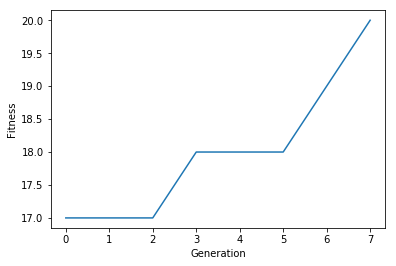

8

In [16]:
runGA(100, 0.7, 0.0)